In [1]:
from IPython.core.display import display,HTML

In [2]:
HTML('''<script>
    hideInput = () => $('div.input').hide();
</script>
<body onload="javascript:hideInput()"></body>''')

In [3]:
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

# Assignment 7

Link to questions - [here](https://docs.google.com/document/d/1o7tMfmpS5XhLc9YpQHV92ZJs1YgyZ40-G98zOVH_0_8/edit?usp=sharing)

***Student Details:***

- Name : Anjishnu Mukherjee
- Registration Number : B05-511017020
- Class Roll Number : CS Gy-70
- Exam Roll Number : 510517086
- Email : 511017020.anjishnu@students.iiests.ac.in

## Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os, cv2
import numpy as np
from os import listdir
from os.path import join
import pandas as pd
import seaborn as sn

print(tf.__version__)

2.3.0


## Explore and preprocess


### Read CSV

In [6]:
# Remove rows with duplicate values in column 'Text'
df1=pd.read_csv('/content/drive/My Drive/ML_LAB/Assign_7/dataset/Reviews.csv').drop_duplicates(subset='Text', keep="last")
df=df1.sample(frac=1,random_state=5).reset_index(drop=True) # Random shuffle
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,149687,B001EPQRGG,A14OQ67LM79KW3,"Candace Mike N Elmo ""candacemikenelmo""",0,0,5,1265587200,if you can get a coffe hater to drink......,...it must be very good coffee.<br />after yea...
1,393601,B001ET5XVW,A39CC8SWYBILWO,LHK,1,2,4,1266796800,Love this - great taste!,Bought this on a lark when I was ordering toma...
2,393464,B001SATUF2,A8WIS8WGO3B30,"stonrdude ""dude""",0,0,5,1328313600,Awesome Product!,King Kelly is the best Orange Marmalade ever t...
3,479900,B0037QTMD0,A804FIHJ3P9UI,W. J. Costlow,1,3,5,1315008000,Yummy,If you have not tried this combination you rea...
4,175089,B002TXT502,A23X9QV9XPU9MG,BekahKnits,1,1,5,1293753600,Best Thing is the Price,I've been buying 3 lb. bags of Gluten Free oat...


### Assign sentiment and create list for labels & reviews

In [7]:
reviews=[]
labels=[]

for ind in range(len(df)):
  text=df.loc[ind,'Text']
  if text:  # valid text string
    reviews.append(df.loc[ind,'Text'])
    if df.loc[ind,'Score']>3: # positive review
      labels.append(1)
    else: # negative review
      labels.append(0)

### Convert reviews into sequences of word indices
* A "word index" would be an ID for the word
* Sequences are truncated to a maximum length of 100 words

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Convert all text samples in the dataset into sequences of "word indices"
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
print("Length of sequences: ",len(sequences))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Upper limit for length of a sequence
MAX_SEQUENCE_LENGTH=100
reviews = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# One hot encode the labels
labels = keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', reviews.shape)
print('Shape of label tensor:', labels.shape)

Length of sequences:  393579
Found 133039 unique tokens.
Shape of data tensor: (393579, 100)
Shape of label tensor: (393579, 2)


### Make separate lists for positive and negative reviews

In [9]:
pos_reviews=[]
neg_reviews=[]
pos_labels=[]
neg_labels=[]

for ind in range(len(reviews)):
  if labels[ind][0]==0: # negative
    neg_labels.append(labels[ind])
    neg_reviews.append(reviews[ind])
  else:
    pos_labels.append(labels[ind])
    pos_reviews.append(reviews[ind])
  
print("Positive reviews #",len(pos_reviews))
print("Negative reviews #",len(neg_reviews))

Positive reviews # 86823
Negative reviews # 306756


### Build train, validation, test data
*  10000 reviews are considered for training
*  2000 reviews are considered for each test and validation sets
*  For each of the three segments, equal number of pos. and neg. reviews are taken 



In [10]:
x_train=pos_reviews[:5000]
x_train+=neg_reviews[:5000]
y_train=pos_labels[:5000]
y_train+=neg_labels[:5000]

x_valid=pos_reviews[5000:6000]
x_valid+=neg_reviews[5000:6000]
y_valid=pos_labels[5000:6000]
y_valid+=neg_labels[5000:6000]

x_test=pos_reviews[6000:7000]
x_test+=neg_reviews[6000:7000]
y_test=pos_labels[6000:7000]
y_test+=neg_labels[6000:7000]

print("Training ",len(x_train))
print("Validation ",len(x_valid))
print("Test ",len(x_test))

Training  10000
Validation  2000
Test  2000


### Storing and retrieving the data variables

In [11]:
# store data variable for access later
import pickle

path='/content/drive/My Drive/ML_LAB/Assign_7'
with open(path+'/reviews_ttv_n.pickle', 'wb') as f:
  pickle.dump([x_train,y_train,x_valid,y_valid,x_test,y_test], f)

In [12]:
# retrieve data using pickle
import pickle

path='/content/drive/My Drive/ML_LAB/Assign_7'
with open(path+'/reviews_ttv_n.pickle', 'rb') as f:
  x_train, y_train, x_valid, y_valid, x_test, y_test = pickle.load(f)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_valid=np.asarray(x_valid)
y_valid=np.asarray(y_valid)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

### Preparing the embedding matrix
* Using the pre-trained GloVe embedding which will contain at index `i` the embedding vector for the word of index `i` in our word index. 

In [13]:
embeddings_index = {}

GLOVE_DIR='/content/drive/My Drive/ML_LAB/Assign_7/'
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
# Building the embedding matrix
EMBEDDING_DIM=100 # number of dimensions for a word
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Storing and retrieving the data variables

In [15]:
# store data variable for access later
import pickle

path='/content/drive/My Drive/ML_LAB/Assign_7'
with open(path+'/embedmat_wordind_n.pickle', 'wb') as f:
  pickle.dump([embedding_matrix,word_index], f)

In [16]:
# retrieve data using pickle
import pickle

path='/content/drive/My Drive/ML_LAB/Assign_7'
with open(path+'/embedmat_wordind_n.pickle', 'rb') as f:
  embedding_matrix,word_index = pickle.load(f)

## Building Model

### Utility function to plot accuracy and loss


In [17]:
def plotHistory(history,title1,title2):
  plt.figure(figsize=(10,5))
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title1)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  # summarize history for loss
  plt.figure(figsize=(10,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title2)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

### Importing keras

In [18]:
from keras import models,layers

### GloVe Embedding layer

In [19]:
from keras.layers import Embedding

EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH=100

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Model 1 (1 LSTM-64)

In [20]:
model1 = keras.Sequential()
model1.add(embedding_layer)
model1.add(layers.LSTM(64,activation='relu'))
model1.add(layers.Dense(2,activation='softmax'))
  
model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 18s 226ms/step - loss: 0.9867 - accuracy: 0.5639 - val_loss: 0.6866 - val_accuracy: 0.5345
Epoch 2/10
79/79 [==============================] - 18s 222ms/step - loss: 0.6711 - accuracy: 0.5991 - val_loss: 0.6743 - val_accuracy: 0.5965
Epoch 3/10
79/79 [==============================] - 17s 218ms/step - loss: 0.6672 - accuracy: 0.6130 - val_loss: 0.6726 - val_accuracy: 0.6010
Epoch 4/10
79/79 [==============================] - 18s 227ms/step - loss: 0.6650 - accuracy: 0.6139 - val_loss: 0.6710 - val_accuracy: 0.6010
Epoch 5/10
79/79 [==============================] - 17s 221ms/step - loss: 0.6627 - accuracy: 0.6191 - val_loss: 0.6697 - val_accuracy: 0.5985
Epoch 6/10
79/79 [==============================] - 18s 227ms/step - loss: 0.6603 - accuracy: 0.6202 - val_loss: 0.6672 - val_accuracy: 0.6060
Epoch 7/10
79/79 [==============================] - 17s 214ms/step - loss: 9.2332 - accuracy: 0.5924 - val_loss: 0.6931 - val_accuracy: 0.5135

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 13,346,370
Trainable params: 42,370
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 1s 19ms/step - loss: 0.6709 - accuracy: 0.5965
test loss, test acc: [0.6708700060844421, 0.5964999794960022]


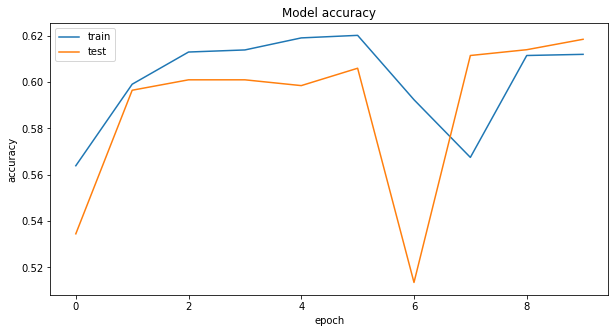

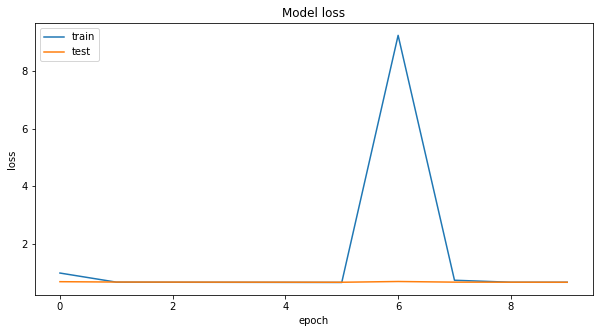

In [21]:
# summary and history

# summary
model1.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history1,'Model accuracy','Model loss')

### Model 2 (1 GRU-64)

In [22]:
model2 = keras.Sequential()
model2.add(embedding_layer)
model2.add(layers.GRU(64,activation='relu'))
model2.add(layers.Dense(2,activation='softmax'))
  
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 21s 267ms/step - loss: 0.6709 - accuracy: 0.5844 - val_loss: 0.6357 - val_accuracy: 0.6450
Epoch 2/10
79/79 [==============================] - 23s 290ms/step - loss: 0.5604 - accuracy: 0.7153 - val_loss: 0.4856 - val_accuracy: 0.7705
Epoch 3/10
79/79 [==============================] - 22s 284ms/step - loss: 0.4819 - accuracy: 0.7733 - val_loss: 0.4577 - val_accuracy: 0.7820
Epoch 4/10
79/79 [==============================] - 23s 285ms/step - loss: 0.4497 - accuracy: 0.7927 - val_loss: 0.4492 - val_accuracy: 0.7970
Epoch 5/10
79/79 [==============================] - 22s 280ms/step - loss: 0.4325 - accuracy: 0.8010 - val_loss: 0.4427 - val_accuracy: 0.7975
Epoch 6/10
79/79 [==============================] - 21s 266ms/step - loss: 0.4098 - accuracy: 0.8100 - val_loss: 0.4251 - val_accuracy: 0.8085
Epoch 7/10
79/79 [==============================] - 22s 278ms/step - loss: 0.3917 - accuracy: 0.8264 - val_loss: 0.4852 - val_accuracy: 0.7735

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru (GRU)                    (None, 64)                31872     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 13,336,002
Trainable params: 32,002
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 1s 21ms/step - loss: 0.3924 - accuracy: 0.8235
test loss, test acc: [0.39243075251579285, 0.8234999775886536]


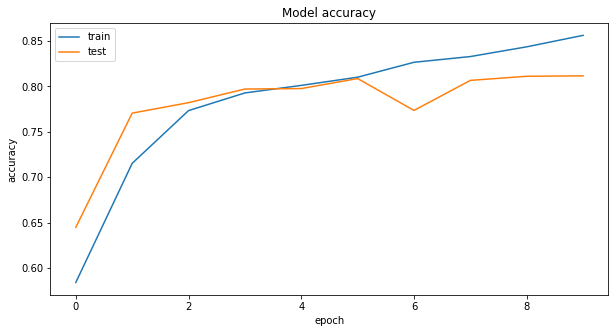

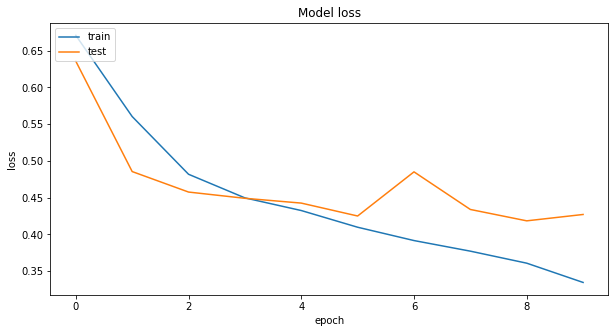

In [23]:
# summary and history

# summary
model2.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model2.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history2,'Model accuracy','Model loss')

### Best model so far is model 2 (using GRU)

### Model 3 (1 GRU-32)

In [24]:
model3 = keras.Sequential()
model3.add(embedding_layer)
model3.add(layers.GRU(32,activation='relu'))
model3.add(layers.Dense(2,activation='softmax'))
  
model3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history3 = model3.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 23s 288ms/step - loss: 0.6789 - accuracy: 0.5679 - val_loss: 0.6570 - val_accuracy: 0.6085
Epoch 2/10
79/79 [==============================] - 21s 264ms/step - loss: 0.6003 - accuracy: 0.6712 - val_loss: 0.5199 - val_accuracy: 0.7525
Epoch 3/10
79/79 [==============================] - 22s 278ms/step - loss: 0.4948 - accuracy: 0.7585 - val_loss: 0.5435 - val_accuracy: 0.7280
Epoch 4/10
79/79 [==============================] - 24s 309ms/step - loss: 0.4648 - accuracy: 0.7767 - val_loss: 0.4513 - val_accuracy: 0.7925
Epoch 5/10
79/79 [==============================] - 22s 284ms/step - loss: 0.4419 - accuracy: 0.7918 - val_loss: 0.4550 - val_accuracy: 0.7855
Epoch 6/10
79/79 [==============================] - 23s 288ms/step - loss: 0.4283 - accuracy: 0.8016 - val_loss: 0.4308 - val_accuracy: 0.8000
Epoch 7/10
79/79 [==============================] - 23s 292ms/step - loss: 0.4088 - accuracy: 0.8109 - val_loss: 0.4280 - val_accuracy: 0.8050

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 13,316,930
Trainable params: 12,930
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 24ms/step - loss: 0.4007 - accuracy: 0.8210
test loss, test acc: [0.40069156885147095, 0.8209999799728394]


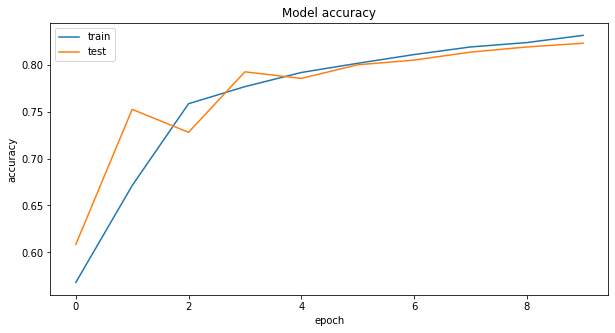

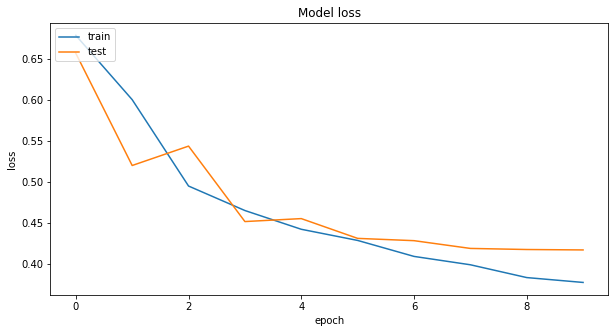

In [25]:
# summary and history

# summary
model3.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model3.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history3,'Model accuracy','Model loss')

### Model 4 (1 GRU-128)

In [26]:
model4 = keras.Sequential()
model4.add(embedding_layer)
model4.add(layers.GRU(128,activation='relu'))
model4.add(layers.Dense(2,activation='softmax'))
  
model4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history4 = model4.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 22s 280ms/step - loss: 0.6614 - accuracy: 0.5955 - val_loss: 0.5921 - val_accuracy: 0.6855
Epoch 2/10
79/79 [==============================] - 22s 279ms/step - loss: 0.5088 - accuracy: 0.7517 - val_loss: 0.4978 - val_accuracy: 0.7630
Epoch 3/10
79/79 [==============================] - 23s 287ms/step - loss: 0.4607 - accuracy: 0.7873 - val_loss: 0.4864 - val_accuracy: 0.7635
Epoch 4/10
79/79 [==============================] - 23s 288ms/step - loss: 0.4268 - accuracy: 0.8046 - val_loss: 0.4454 - val_accuracy: 0.7925
Epoch 5/10
79/79 [==============================] - 22s 272ms/step - loss: 0.3984 - accuracy: 0.8185 - val_loss: 0.4240 - val_accuracy: 0.8090
Epoch 6/10
79/79 [==============================] - 22s 284ms/step - loss: 0.3747 - accuracy: 0.8378 - val_loss: 0.4358 - val_accuracy: 0.7995
Epoch 7/10
79/79 [==============================] - 22s 282ms/step - loss: 0.3479 - accuracy: 0.8439 - val_loss: 0.4010 - val_accuracy: 0.8200

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 13,392,578
Trainable params: 88,578
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 25ms/step - loss: 0.3892 - accuracy: 0.8385
test loss, test acc: [0.389176607131958, 0.8385000228881836]


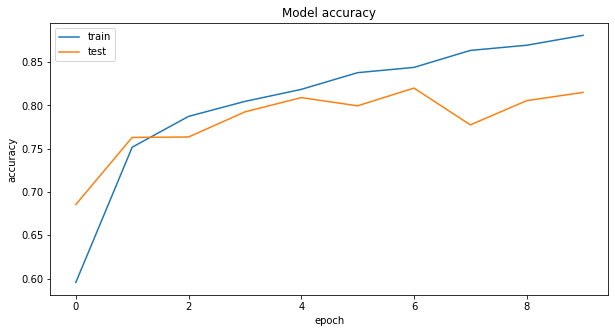

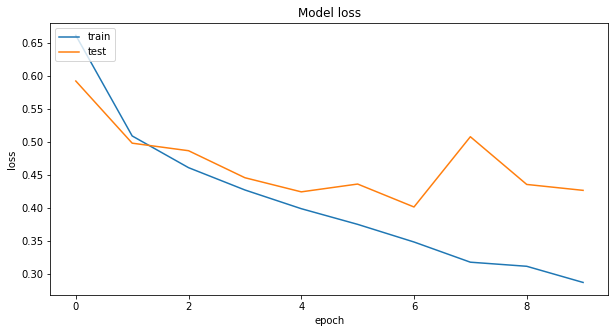

In [27]:
# summary and history

# summary
model4.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model4.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history4,'Model accuracy','Model loss')

### Now, Model 4 is the best performing
For stacked LSTMs/GRUs, add `return_sequences=True` for all but the last of those layers

### Model 5 (2 GRU-128)

In [28]:
model5 = keras.Sequential()
model5.add(embedding_layer)
model5.add(layers.GRU(128,activation='relu',return_sequences=True))
model5.add(layers.GRU(128,activation='relu'))
model5.add(layers.Dense(2,activation='softmax'))
  
model5.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history5 = model5.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 46s 576ms/step - loss: 0.6601 - accuracy: 0.5907 - val_loss: 0.6114 - val_accuracy: 0.6945
Epoch 2/10
79/79 [==============================] - 45s 565ms/step - loss: 0.5187 - accuracy: 0.7409 - val_loss: 0.4645 - val_accuracy: 0.7810
Epoch 3/10
79/79 [==============================] - 43s 545ms/step - loss: 0.4365 - accuracy: 0.8002 - val_loss: 0.4318 - val_accuracy: 0.8020
Epoch 4/10
79/79 [==============================] - 44s 557ms/step - loss: 0.4137 - accuracy: 0.8116 - val_loss: 0.4131 - val_accuracy: 0.8155
Epoch 5/10
79/79 [==============================] - 45s 567ms/step - loss: 0.3721 - accuracy: 0.8365 - val_loss: 0.4069 - val_accuracy: 0.8180
Epoch 6/10
79/79 [==============================] - 44s 556ms/step - loss: 0.3492 - accuracy: 0.8487 - val_loss: 0.3951 - val_accuracy: 0.8275
Epoch 7/10
79/79 [==============================] - 45s 571ms/step - loss: 0.3226 - accuracy: 0.8611 - val_loss: 0.4206 - val_accuracy: 0.8185

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 13,491,650
Trainable params: 187,650
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 40ms/step - loss: 0.4028 - accuracy: 0.8375
test loss, test acc: [0.4027763307094574, 0.8374999761581421]


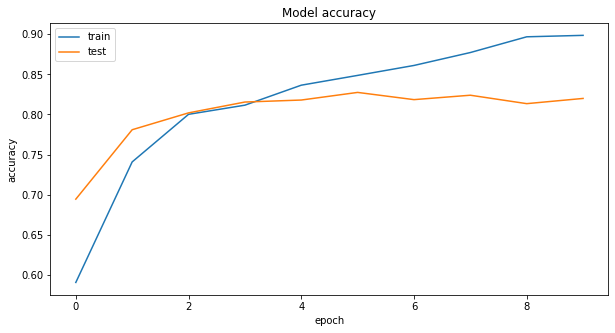

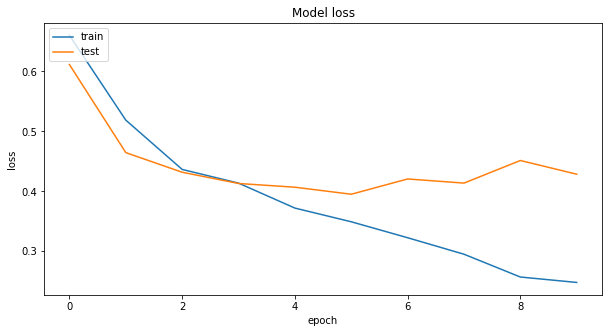

In [29]:
# summary and history

# summary
model5.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model5.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history5,'Model accuracy','Model loss')

In [30]:
model5.save('/content/drive/My Drive/ML_LAB/Assign_7/model5_n.h5')

In [31]:
model5=models.load_model('/content/drive/My Drive/ML_LAB/Assign_7/model5_n.h5')
results = model5.evaluate(x_test, y_test)

63/63 [==============================] - 3s 47ms/step - loss: 0.4028 - accuracy: 0.8375


### Model 6 (3 GRU-128)

In [32]:
model6 = keras.Sequential()
model6.add(embedding_layer)
model6.add(layers.GRU(128,activation='relu',return_sequences=True))
model6.add(layers.GRU(128,activation='relu',return_sequences=True))
model6.add(layers.GRU(128,activation='relu'))
model6.add(layers.Dense(2,activation='softmax'))
  
model6.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history6 = model6.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 68s 856ms/step - loss: 0.6592 - accuracy: 0.5894 - val_loss: 0.5878 - val_accuracy: 0.6900
Epoch 2/10
79/79 [==============================] - 66s 830ms/step - loss: 0.5170 - accuracy: 0.7471 - val_loss: 0.5811 - val_accuracy: 0.7065
Epoch 3/10
79/79 [==============================] - 65s 818ms/step - loss: 0.4507 - accuracy: 0.7899 - val_loss: 0.4405 - val_accuracy: 0.7935
Epoch 4/10
79/79 [==============================] - 65s 822ms/step - loss: 0.4192 - accuracy: 0.8047 - val_loss: 0.4772 - val_accuracy: 0.7740
Epoch 5/10
79/79 [==============================] - 65s 829ms/step - loss: 0.3786 - accuracy: 0.8284 - val_loss: 0.4281 - val_accuracy: 0.8015
Epoch 6/10
79/79 [==============================] - 65s 826ms/step - loss: 0.3764 - accuracy: 0.8293 - val_loss: 0.3978 - val_accuracy: 0.8240
Epoch 7/10
79/79 [==============================] - 65s 825ms/step - loss: 0.3368 - accuracy: 0.8531 - val_loss: 0.3952 - val_accuracy: 0.8315

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_5 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_6 (GRU)                  (None, 100, 128)          99072     
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 13,590,722
Trainable params: 286,722
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 4s 60ms/step - loss: 0.4078 - accuracy:

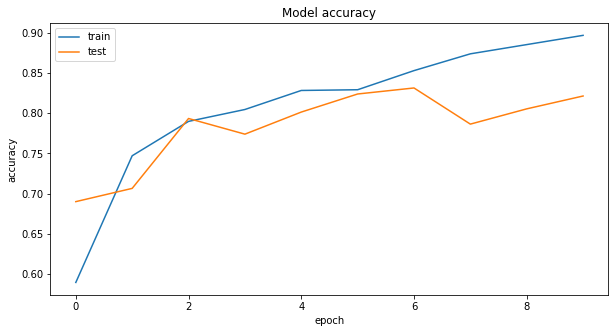

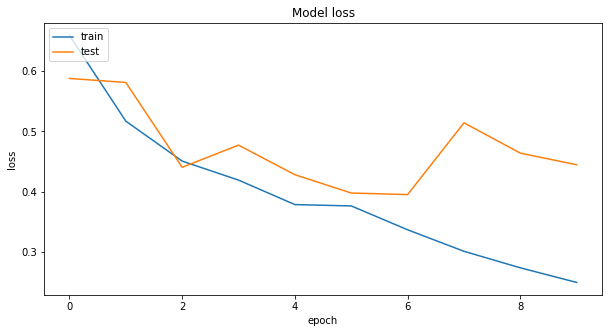

In [33]:
# summary and history

# summary
model6.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model6.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history6,'Model accuracy','Model loss')

### Model 7 (4 GRU-128)

In [34]:
model7 = keras.Sequential()
model7.add(embedding_layer)
model7.add(layers.GRU(128,activation='relu',return_sequences=True))
model7.add(layers.GRU(128,activation='relu',return_sequences=True))
model7.add(layers.GRU(128,activation='relu',return_sequences=True))
model7.add(layers.GRU(128,activation='relu'))
model7.add(layers.Dense(2,activation='softmax'))
  
model7.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history7 = model7.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 85s 1s/step - loss: 0.6706 - accuracy: 0.5734 - val_loss: 0.6438 - val_accuracy: 0.6495
Epoch 2/10
79/79 [==============================] - 84s 1s/step - loss: 0.5240 - accuracy: 0.7448 - val_loss: 0.4785 - val_accuracy: 0.7750
Epoch 3/10
79/79 [==============================] - 84s 1s/step - loss: 0.4418 - accuracy: 0.7947 - val_loss: 0.4533 - val_accuracy: 0.7855
Epoch 4/10
79/79 [==============================] - 85s 1s/step - loss: 0.4117 - accuracy: 0.8136 - val_loss: 0.4018 - val_accuracy: 0.8150
Epoch 5/10
79/79 [==============================] - 85s 1s/step - loss: 0.3696 - accuracy: 0.8361 - val_loss: 0.4564 - val_accuracy: 0.7865
Epoch 6/10
79/79 [==============================] - 84s 1s/step - loss: 0.3660 - accuracy: 0.8414 - val_loss: 0.4083 - val_accuracy: 0.8210
Epoch 7/10
79/79 [==============================] - 84s 1s/step - loss: 0.3218 - accuracy: 0.8664 - val_loss: 0.4090 - val_accuracy: 0.8165
Epoch 8/10
79/79 [==

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_8 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_9 (GRU)                  (None, 100, 128)          99072     
_________________________________________________________________
gru_10 (GRU)                 (None, 100, 128)          99072     
_________________________________________________________________
gru_11 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 13,689,794
Trainable params: 385,794
Non-trainable params: 13,304,000
____________________________________

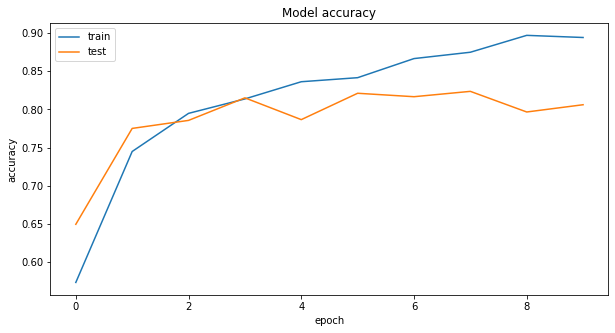

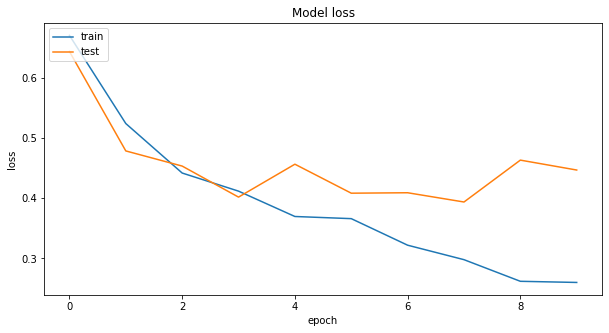

In [35]:
# summary and history

# summary
model7.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model7.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history7,'Model accuracy','Model loss')

### Model 5 is the best performing so far

### Model 8 (2 Bidirectional GRU-128)

In [36]:
model8 = keras.Sequential()
model8.add(embedding_layer)
model8.add(layers.Bidirectional(layers.GRU(128,activation='relu',return_sequences=True)))
model8.add(layers.Bidirectional(layers.GRU(128,activation='relu')))
model8.add(layers.Dense(2,activation='softmax'))
  
model8.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history8 = model8.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 83s 1s/step - loss: 0.6407 - accuracy: 0.6191 - val_loss: 0.6861 - val_accuracy: 0.5845
Epoch 2/10
79/79 [==============================] - 85s 1s/step - loss: 0.4998 - accuracy: 0.7569 - val_loss: 0.6557 - val_accuracy: 0.6735
Epoch 3/10
79/79 [==============================] - 83s 1s/step - loss: 0.4660 - accuracy: 0.7813 - val_loss: 0.4682 - val_accuracy: 0.7725
Epoch 4/10
79/79 [==============================] - 83s 1s/step - loss: 0.3949 - accuracy: 0.8208 - val_loss: 0.4095 - val_accuracy: 0.8170
Epoch 5/10
79/79 [==============================] - 82s 1s/step - loss: 0.3648 - accuracy: 0.8387 - val_loss: 0.4522 - val_accuracy: 0.7875
Epoch 6/10
79/79 [==============================] - 80s 1s/step - loss: 0.3534 - accuracy: 0.8446 - val_loss: 0.4024 - val_accuracy: 0.8295
Epoch 7/10
79/79 [==============================] - 82s 1s/step - loss: 0.3001 - accuracy: 0.8729 - val_loss: 0.4158 - val_accuracy: 0.8195
Epoch 8/10
79/79 [==

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          176640    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 13,777,602
Trainable params: 473,602
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 5s 72ms/step - loss: 0.5424 - accuracy: 0.7910
test loss, test acc: [0.5423805117607117, 0.7910000085830688]


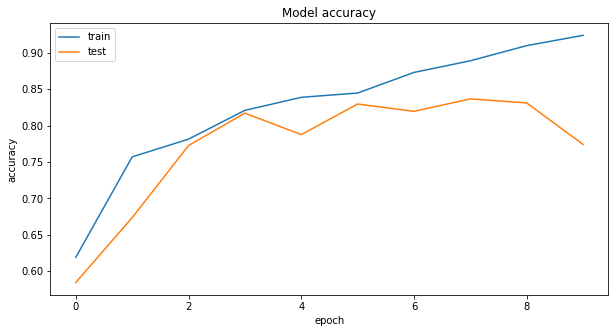

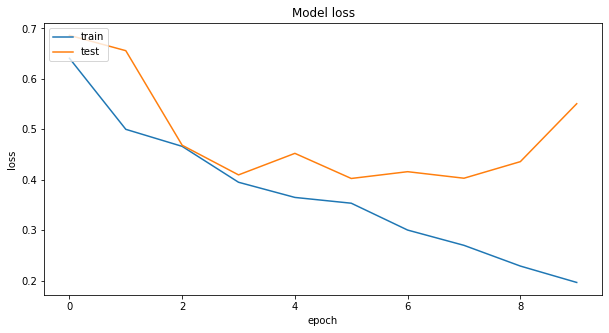

In [37]:
# summary and history

# summary
model8.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model8.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history8,'Model accuracy','Model loss')

### Still, Model 5 is the best performing

### Model 9 (2 GRU-128 dropout=0.1)

In [38]:
model9 = keras.Sequential()
model9.add(embedding_layer)
model9.add(layers.GRU(128,activation='relu',dropout=0.1,return_sequences=True))
model9.add(layers.GRU(128,activation='relu',dropout=0.1))
model9.add(layers.Dense(2,activation='softmax'))
  
model9.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history9 = model9.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 48s 604ms/step - loss: 0.6687 - accuracy: 0.5840 - val_loss: 0.6305 - val_accuracy: 0.6575
Epoch 2/10
79/79 [==============================] - 47s 599ms/step - loss: 0.5712 - accuracy: 0.7052 - val_loss: 0.5294 - val_accuracy: 0.7365
Epoch 3/10
79/79 [==============================] - 49s 622ms/step - loss: 0.4826 - accuracy: 0.7644 - val_loss: 0.4429 - val_accuracy: 0.7920
Epoch 4/10
79/79 [==============================] - 48s 609ms/step - loss: 0.4367 - accuracy: 0.7960 - val_loss: 0.4267 - val_accuracy: 0.8070
Epoch 5/10
79/79 [==============================] - 49s 619ms/step - loss: 0.4190 - accuracy: 0.8072 - val_loss: 0.4235 - val_accuracy: 0.8085
Epoch 6/10
79/79 [==============================] - 49s 614ms/step - loss: 0.3955 - accuracy: 0.8219 - val_loss: 0.4039 - val_accuracy: 0.8175
Epoch 7/10
79/79 [==============================] - 45s 574ms/step - loss: 0.3775 - accuracy: 0.8313 - val_loss: 0.4066 - val_accuracy: 0.8210

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_14 (GRU)                 (None, 100, 128)          88320     
_________________________________________________________________
gru_15 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 13,491,650
Trainable params: 187,650
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 37ms/step - loss: 0.4205 - accuracy: 0.8200
test loss, test acc: [0.4205341935157776, 0.8199999928474426]


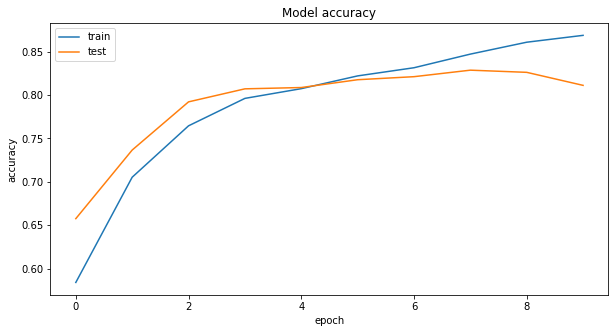

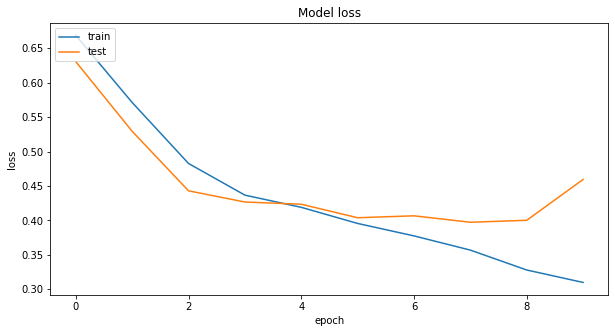

In [39]:
# summary and history

# summary
model9.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model9.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history9,'Model accuracy','Model loss')

### Model 10 (2 GRU-128 recurrent dropout=0.2)

In [20]:
model10 = keras.Sequential()
model10.add(embedding_layer)
model10.add(layers.GRU(128,activation='relu',recurrent_dropout=0.2,return_sequences=True))
model10.add(layers.GRU(128,activation='relu',recurrent_dropout=0.2))
model10.add(layers.Dense(2,activation='softmax'))
  
model10.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history10 = model10.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 43s 540ms/step - loss: 0.6658 - accuracy: 0.5871 - val_loss: 0.6432 - val_accuracy: 0.6335
Epoch 2/10
79/79 [==============================] - 42s 531ms/step - loss: 0.5327 - accuracy: 0.7316 - val_loss: 0.4648 - val_accuracy: 0.7860
Epoch 3/10
79/79 [==============================] - 42s 532ms/step - loss: 0.4579 - accuracy: 0.7850 - val_loss: 0.5071 - val_accuracy: 0.7505
Epoch 4/10
79/79 [==============================] - 42s 533ms/step - loss: 0.4273 - accuracy: 0.8065 - val_loss: 0.4267 - val_accuracy: 0.8005
Epoch 5/10
79/79 [==============================] - 42s 532ms/step - loss: 0.3967 - accuracy: 0.8218 - val_loss: 0.4169 - val_accuracy: 0.8120
Epoch 6/10
79/79 [==============================] - 42s 527ms/step - loss: 0.3631 - accuracy: 0.8436 - val_loss: 0.5645 - val_accuracy: 0.7385
Epoch 7/10
79/79 [==============================] - 42s 527ms/step - loss: 0.3517 - accuracy: 0.8506 - val_loss: 0.3982 - val_accuracy: 0.8220

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru (GRU)                    (None, 100, 128)          88320     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 13,491,650
Trainable params: 187,650
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 3s 48ms/step - loss: 0.3861 - accuracy: 0.8365
test loss, test acc: [0.38611656427383423, 0.8364999890327454]


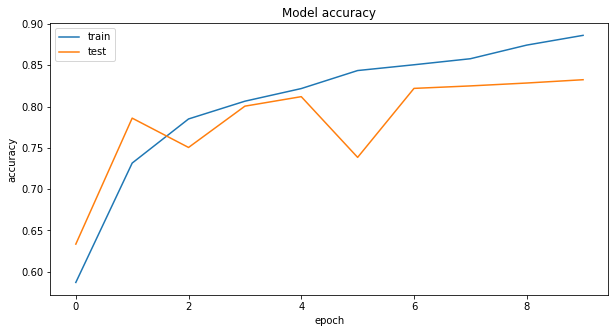

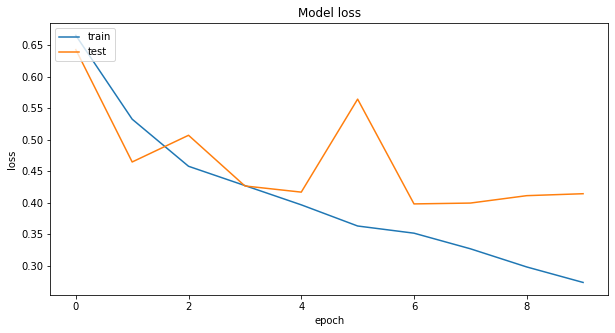

In [21]:
# summary and history

# summary
model10.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model10.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history10,'Model accuracy','Model loss')

### Model 11 (2 GRU-128 dropout=0.1 + recurrent dropout=0.2)

In [22]:
model11 = keras.Sequential()
model11.add(embedding_layer)
model11.add(layers.GRU(128,activation='relu',dropout=0.1,recurrent_dropout=0.2,return_sequences=True))
model11.add(layers.GRU(128,activation='relu',dropout=0.1,recurrent_dropout=0.2))
model11.add(layers.Dense(2,activation='softmax'))
  
model11.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history11 = model11.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 49s 617ms/step - loss: 0.6742 - accuracy: 0.5827 - val_loss: 0.6221 - val_accuracy: 0.6575
Epoch 2/10
79/79 [==============================] - 48s 605ms/step - loss: 0.5510 - accuracy: 0.7198 - val_loss: 0.4776 - val_accuracy: 0.7770
Epoch 3/10
79/79 [==============================] - 48s 612ms/step - loss: 0.4656 - accuracy: 0.7804 - val_loss: 0.4649 - val_accuracy: 0.7755
Epoch 4/10
79/79 [==============================] - 47s 599ms/step - loss: 0.4531 - accuracy: 0.7871 - val_loss: 0.4272 - val_accuracy: 0.8040
Epoch 5/10
79/79 [==============================] - 47s 595ms/step - loss: 0.4138 - accuracy: 0.8073 - val_loss: 0.4218 - val_accuracy: 0.8080
Epoch 6/10
79/79 [==============================] - 47s 596ms/step - loss: 0.3910 - accuracy: 0.8233 - val_loss: 0.3976 - val_accuracy: 0.8165
Epoch 7/10
79/79 [==============================] - 47s 592ms/step - loss: 0.3662 - accuracy: 0.8372 - val_loss: 0.5794 - val_accuracy: 0.7475

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 13,491,650
Trainable params: 187,650
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 3s 46ms/step - loss: 0.3601 - accuracy: 0.8440
test loss, test acc: [0.3601447641849518, 0.843999981880188]


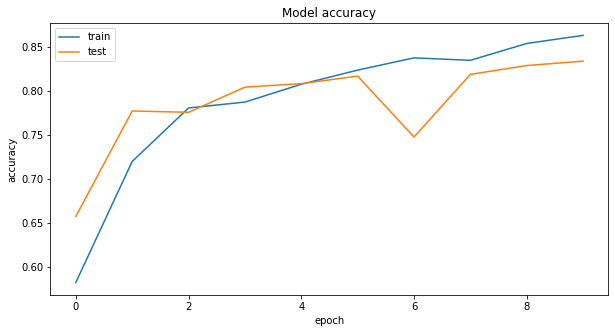

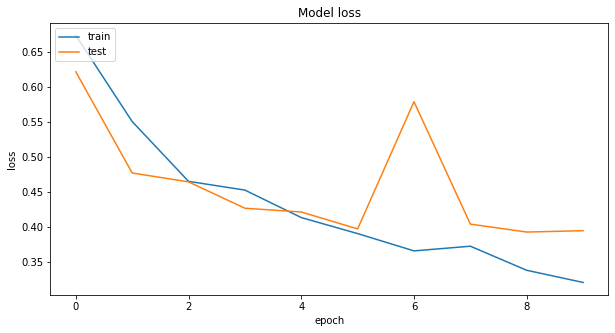

In [23]:
# summary and history

# summary
model11.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model11.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history11,'Model accuracy','Model loss')

### Model 12 (2 GRU-128 bias_regularizer=0.05)

In [24]:
model12 = keras.Sequential()
model12.add(embedding_layer)
model12.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu',return_sequences=True))
model12.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu'))
model12.add(layers.Dense(2,activation='softmax'))
  
model12.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history12 = model12.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 28s 353ms/step - loss: 0.6606 - accuracy: 0.6134 - val_loss: 0.5524 - val_accuracy: 0.7325
Epoch 2/10
79/79 [==============================] - 27s 341ms/step - loss: 0.5203 - accuracy: 0.7509 - val_loss: 0.5140 - val_accuracy: 0.7485
Epoch 3/10
79/79 [==============================] - 27s 343ms/step - loss: 0.4593 - accuracy: 0.7901 - val_loss: 0.4940 - val_accuracy: 0.7730
Epoch 4/10
79/79 [==============================] - 27s 347ms/step - loss: 0.4259 - accuracy: 0.8073 - val_loss: 0.4768 - val_accuracy: 0.7810
Epoch 5/10
79/79 [==============================] - 27s 343ms/step - loss: 0.3972 - accuracy: 0.8252 - val_loss: 0.4185 - val_accuracy: 0.8085
Epoch 6/10
79/79 [==============================] - 27s 339ms/step - loss: 0.3745 - accuracy: 0.8391 - val_loss: 0.4047 - val_accuracy: 0.8220
Epoch 7/10
79/79 [==============================] - 27s 346ms/step - loss: 0.3448 - accuracy: 0.8567 - val_loss: 0.4238 - val_accuracy: 0.8205

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          13304000  
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 13,491,650
Trainable params: 187,650
Non-trainable params: 13,304,000
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 32ms/step - loss: 0.4138 - accuracy: 0.8295
test loss, test acc: [0.4138040244579315, 0.8295000195503235]


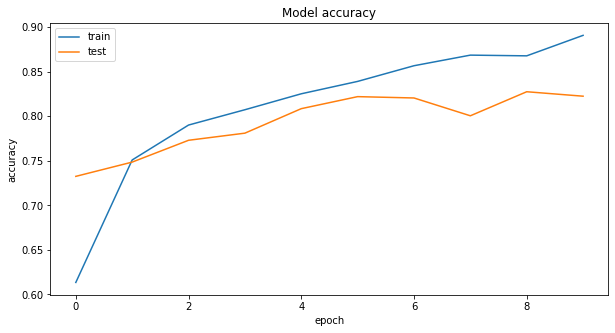

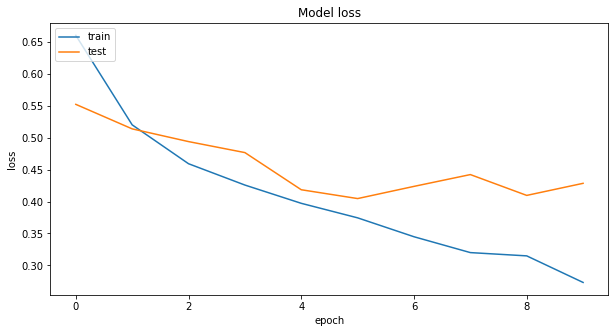

In [25]:
# summary and history

# summary
model12.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model12.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history12,'Model accuracy','Model loss')

In [26]:
model12.save('/content/drive/My Drive/ML_LAB/Assign_7/model12_n.h5')

In [27]:
model12=models.load_model('/content/drive/My Drive/ML_LAB/Assign_7/model12_n.h5')
results = model12.evaluate(x_test, y_test)

63/63 [==============================] - 2s 32ms/step - loss: 0.4138 - accuracy: 0.8295


### Now, Model 12 is the best performing

### Model 13 (2 GRU-128 bias_regularizer=0.05 self-trainable embedding)

In [28]:
model13 = keras.Sequential()
model13.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      trainable=True,
                      input_length=MAX_SEQUENCE_LENGTH))
model13.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu',return_sequences=True))
model13.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu'))
model13.add(layers.Dense(2,activation='softmax'))
  
model13.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history13 = model13.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_valid, y_valid))

Epoch 1/10
79/79 [==============================] - 39s 488ms/step - loss: 0.6252 - accuracy: 0.6569 - val_loss: 0.5707 - val_accuracy: 0.7460
Epoch 2/10
79/79 [==============================] - 38s 477ms/step - loss: 0.3760 - accuracy: 0.8526 - val_loss: 0.4734 - val_accuracy: 0.7925
Epoch 3/10
79/79 [==============================] - 37s 472ms/step - loss: 0.2325 - accuracy: 0.9137 - val_loss: 0.5393 - val_accuracy: 0.7915
Epoch 4/10
79/79 [==============================] - 38s 475ms/step - loss: 0.1441 - accuracy: 0.9496 - val_loss: 0.6843 - val_accuracy: 0.7805
Epoch 5/10
79/79 [==============================] - 37s 465ms/step - loss: 0.1200 - accuracy: 0.9617 - val_loss: 0.7644 - val_accuracy: 0.7735
Epoch 6/10
79/79 [==============================] - 37s 465ms/step - loss: 0.0667 - accuracy: 0.9807 - val_loss: 0.9525 - val_accuracy: 0.7650
Epoch 7/10
79/79 [==============================] - 37s 463ms/step - loss: 0.0698 - accuracy: 0.9778 - val_loss: 1.0368 - val_accuracy: 0.7765

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          13304000  
_________________________________________________________________
gru_6 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 13,491,650
Trainable params: 13,491,650
Non-trainable params: 0
_________________________________________________________________
Evaluate on test data
63/63 [==============================] - 2s 31ms/step - loss: 0.9908 - accuracy: 0.7665
test loss, test acc: [0.9908018708229065, 0.7664999961853027]


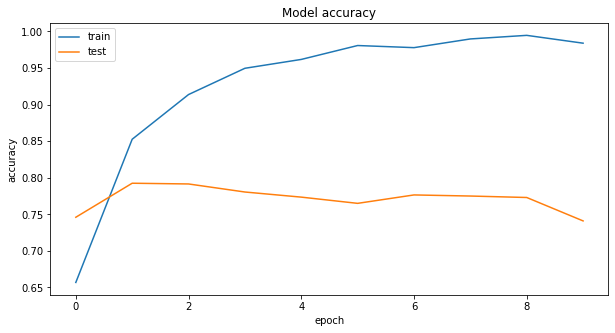

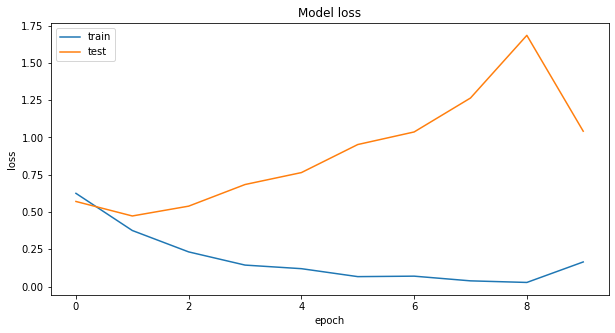

In [29]:
# summary and history

# summary
model13.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model13.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history13,'Model accuracy','Model loss')

### Model 14 (2 GRU-128 bias_regularizer=0.05 one hot encoded embedding) 

- One hot encoding the labels crashes RAM. This is a problem I dont know how to fix. Hence currently not training this model.

In [30]:
#x_train1=[]
#for val in x_train:
#  x_train1.append(keras.utils.to_categorical(val))
#x_train1=np.asarray(x_train1)

#x_valid1=[]
#for val in x_valid:
#  x_valid1.append(keras.utils.to_categorical(val))
#x_valid1=np.asarray(x_valid1)

#x_test1=[]
#for val in x_test:
#  x_test1.append(keras.utils.to_categorical(val))
#x_test1=np.asarray(x_test1)

In [ ]:
model14 = keras.Sequential()
model14.add(Embedding(len(word_index) + 1,
                      input_length=MAX_SEQUENCE_LENGTH))
model14.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu',return_sequences=True))
model14.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu'))
model14.add(layers.Dense(2,activation='softmax'))

model14.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history14 = model14.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_valid, y_valid))

In [ ]:
# summary and history

# summary
model14.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model14.evaluate(x_test, y_test)
print("test loss, test acc:", results)

# history
plotHistory(history14,'Model accuracy','Model loss')

## Checking on my own review

In [32]:
my_rev1="Very grateful for this reliable product. Good flavour and nutrition profile. Good discount as well."
my_rev2="Product is not as specified by the seller. Waste of money."
reviews1=[]
reviews1.append(my_rev1)
reviews1.append(my_rev2)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Convert all text samples in the dataset into sequences of "word indices"
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(reviews1)
sequences1 = tokenizer1.texts_to_sequences(reviews1)
print("Length of sequences: ",len(sequences1))

word_index1 = tokenizer1.word_index
print('Found %s unique tokens.' % len(word_index1))

# Upper limit for length of a sequence
MAX_SEQUENCE_LENGTH=100
reviews1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)

Length of sequences:  2
Found 23 unique tokens.


In [33]:
model12.predict(reviews1)

array([[0.08688124, 0.9131187 ],
       [0.71508634, 0.2849137 ]], dtype=float32)

## Hindi movie reviews dataset

### Read CSV

In [34]:
# Remove rows with duplicate values in column 'text
df1=pd.read_csv('/content/drive/My Drive/ML_LAB/Assign_7/dataset/train.csv').drop_duplicates(subset='text', keep="last")
dfn=df1.sample(frac=1,random_state=5).reset_index(drop=True) # Random shuffle

dfn.head()

,text,experience
0,"\n\nबैनर :\nफॉक्स स्टार स्टुडियो, वाइड फ्रेम प...",2
1,Chandermohan.sharma@timesgroup.com ​बॉलिवुड मे...,0
2,\nडर @ द माल का सबसे बड़ा आकर्षण निर्देशक पवन ...,0
3,सुभाष नागरे या सरकार (अमिताभ बच्चन) महाराष्ट्र...,2
4,बैनर :\nपीवीआर पिक्चर्स\n\nनिर्माता :\nअजय बिज...,2


In [35]:
# Remove rows with duplicate values in column 'Text
df1=pd.read_csv('/content/drive/My Drive/ML_LAB/Assign_7/dataset/valid.csv').drop_duplicates(subset='text', keep="last")
dfn1=df1.sample(frac=1,random_state=5).reset_index(drop=True) # Random shuffle

dfn1.head()

,text,experience
0,\n\nफिल्म के हीरो संजू (इमरान) और उसके दो साथि...,1
1,\nविक्रम सेठी ‍(सिद्धार्थ मल्होत्रा) और माया (...,1
2,"बैनर :\nयूटीवी मोशन पिक्चर्स, आमिर खान प्रोडक्...",2
3,"बैनर :\nयूटीवी मोशन पिक्चर्स, भंडारकर एंटरटेनम...",1
4,\nनिर्माता-निर्देशक विशाल भारद्वाज को साहित्य ...,2


### Assign sentiment and create list for labels & reviews

In [36]:
reviews_n=[]
labels_n=[]

for ind in range(len(dfn)):
  text=dfn.loc[ind,'text']
  if text:  # valid text string
    reviews_n.append(dfn.loc[ind,'text'])
    labels_n.append(dfn.loc[ind,'experience'])

for ind in range(len(dfn1)):
  text=dfn1.loc[ind,'text']
  if text:  # valid text string
    reviews_n.append(dfn1.loc[ind,'text'])
    labels_n.append(dfn1.loc[ind,'experience'])

reviews_n=np.asarray(reviews_n)
labels_n=np.asarray(labels_n)

### Convert reviews into sequences of word indices
* A "word index" would be an ID for the word
* Sequences are truncated to a maximum length of 100 words

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Convert all text samples in the dataset into sequences of "word indices"
tokenizer_n = Tokenizer()
tokenizer_n.fit_on_texts(reviews_n)
sequences_n = tokenizer_n.texts_to_sequences(reviews_n)
print("Length of sequences: ",len(sequences_n))

word_index_n = tokenizer_n.word_index
print('Found %s unique tokens.' % len(word_index_n))

# Upper limit for length of a sequence
MAX_SEQUENCE_LENGTH=100
reviews_n = pad_sequences(sequences_n, maxlen=MAX_SEQUENCE_LENGTH)

# One hot encode the labels
labels_n = keras.utils.to_categorical(np.asarray(labels_n))
print('Shape of data tensor:', reviews_n.shape)
print('Shape of label tensor:', labels_n.shape)

Length of sequences:  898
Found 26030 unique tokens.
Shape of data tensor: (898, 100)
Shape of label tensor: (898, 3)


### Build train, test data
*  80% for training, 10% for validation and 10% for test



In [38]:
x_train_n=reviews_n[:710]
y_train_n=labels_n[:710]

x_valid_n=reviews_n[710:804]
y_valid_n=labels_n[710:804]

x_test_n=reviews_n[804:898]
y_test_n=labels_n[804:898]

print("Training ",len(x_train_n))
print("Validation ",len(x_valid_n))
print("Test ",len(x_test_n))

Training  710
Validation  94
Test  94


### Model X (2 GRU-128 bias_regularizer=0.05 self-trainable embedding)

In [39]:
modelx = keras.Sequential()
modelx.add(Embedding(len(word_index_n) + 1,
                      EMBEDDING_DIM,
                      trainable=True,
                      input_length=MAX_SEQUENCE_LENGTH))
modelx.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu',return_sequences=True))
modelx.add(layers.GRU(128,bias_regularizer=keras.regularizers.L1(0.05),activation='relu'))
modelx.add(layers.Dense(3,activation='softmax'))

modelx.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
historyx = modelx.fit(x_train_n, y_train_n, epochs=20, validation_data=(x_valid_n, y_valid_n))

Epoch 1/20
23/23 [==============================] - 9s 386ms/step - loss: 1.1199 - accuracy: 0.3634 - val_loss: 1.1104 - val_accuracy: 0.3936
Epoch 2/20
23/23 [==============================] - 8s 364ms/step - loss: 1.0910 - accuracy: 0.3859 - val_loss: 1.1136 - val_accuracy: 0.3936
Epoch 3/20
23/23 [==============================] - 8s 369ms/step - loss: 22.1958 - accuracy: 0.5141 - val_loss: 1.2796 - val_accuracy: 0.3617
Epoch 4/20
23/23 [==============================] - 8s 360ms/step - loss: 1.2270 - accuracy: 0.7169 - val_loss: 1.3538 - val_accuracy: 0.3404
Epoch 5/20
23/23 [==============================] - 8s 368ms/step - loss: 1.2641 - accuracy: 0.7394 - val_loss: 1.4439 - val_accuracy: 0.4787
Epoch 6/20
23/23 [==============================] - 8s 361ms/step - loss: 1.3546 - accuracy: 0.5831 - val_loss: 1.4730 - val_accuracy: 0.4574
Epoch 7/20
23/23 [==============================] - 8s 369ms/step - loss: 1.2465 - accuracy: 0.5803 - val_loss: 4.4566 - val_accuracy: 0.4574
Epoch

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2603100   
_________________________________________________________________
gru_8 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 2,790,879
Trainable params: 2,790,879
Non-trainable params: 0
_________________________________________________________________
Evaluate on test data
3/3 [==============================] - 0s 24ms/step - loss: 1.6553 - accuracy: 0.4149
test loss, test acc: [1.6553058624267578, 0.41489362716674805]


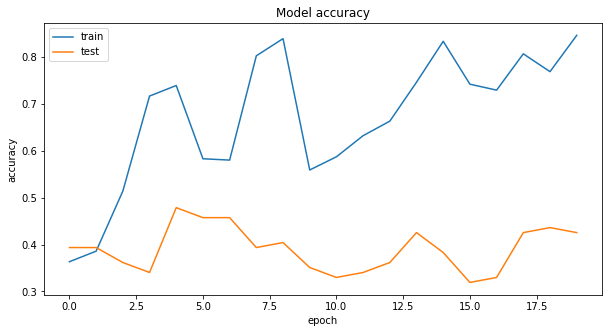

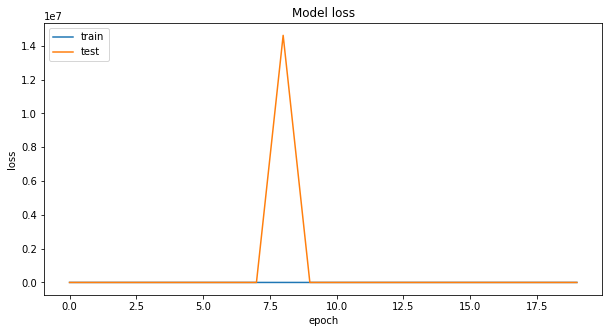

In [40]:
# summary and history

# summary
modelx.summary()
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = modelx.evaluate(x_test_n, y_test_n)
print("test loss, test acc:", results)

# history
plotHistory(historyx,'Model accuracy','Model loss')